# Automatic Modulation Classification.
## A notebook by

| Name             | ID      |
|------------------|---------|
| Mohamed Ashraf   | 1180100 |
| Nour El Seroui   | 1180443 |
| Omar Tarek Ahmed | 1180004 |



# Introduction
The dataset used here can be found [Here](https://www.kaggle.com/datasets/dimitrisf/constellation-dataset). It has a total of 9 modulation schemes over 135k files:

1. PAM 4
2. PAM 16
3. QPSK
4. PSK 8
5. APSK 32
6. APSK 64
7. QAM 16
8. QAM 32 
9. QAM 64

These constellations have random SNRs (ranges from -20, to 20 **dB**) and random rotations.
The uncompressed size of this dataset is about 9 GB spread over approximatley 135k text files of constellation _IQ_ points. The dataset is actually split into three datasets, one of them is the testing set. We use the smaller dataset which is included in the "dataset2" folder. This dataset has about 45k files.

In this document, we will use two methods to automatically classify the modulation scheme of a given constellation. The first method is a support vector machine (**SVM**) classifier, and the second is a K nearest neighbour (**KNN**) classifier.


# Feature Extraction
In the current state, the size of the dataset is not small. This usually means bad news for runtimes. Luckily, we can drastically reduce the size by extracting some features from each text file and keeping the feautres of each text file only. We will use the follwoing features:

1. The first cumulant **(Mean)**
2. The second cumulant **(Variance)**
3. The third cumulant **(Skewness)**
4. The fourth cumulant **(Kurtosis)**

Something worth noting is that these cumulants are not the optimum cumulants for classification using SVM or KNN, but they are much easier to compute. Such trade was made to reduce the runtime of the notebook as it is for educational purposes only. As stated in the lecture, the optimum cumulants for the SVM are the first, second, fourth, and, sixth order cumulants. As stated in [this paper](https://journals.iium.edu.my/ejournal/index.php/iiumej/article/download/641/442/3205), possible cumulants for KNN could be the second, fourth, sixth, and, eighth order cumulants. 

After extracting the first four cumulants from each datapoint (text file) , we can group all obtained data in a *comma separated value* file, or *.csv* for short. If we decide to leave the four cumulants in separate files (for each datapoint), this would significantly hurt the runtime of the notebook by having to read the features from 45k files.

We start by importing the required modules.

In [1]:
import classes as cl
import numpy as np
import scipy.stats as stats
import os
import pandas as pd
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Then, we loop on each file in our dataset (we choose the "dataset 2" folder which has about 45k datapoints) then for each datapoint we add a row in the csv file. This row takes the following form:


| Modulation Scheme | Modulation Order | SNR | Rotation | First Cumulant | Second Cumulant | Third Cumulant | Fourth Cumulant |
|-------------------|------------------|-----|----------|----------------|-----------------|----------------|-----------------|


**Note**: As long as the file _features.csv_ exists, the feature extraction part, the longest part of this notebook in terms of runtime, will not run again. Not only does this reduce runtime significantly, but it also prevents us from overwriting the file if we run the notebook again.

In [2]:
if not os.path.isfile('features.csv'):
    # Set the path for the dataset in use
    dataset_2_path = './Dataset2/'

    # Open a text file to write the extraced features to
    with open('features.csv', 'w') as f:

        # for each text file in the dataset
        for file in os.listdir(dataset_2_path):

            try:

                # Create a DataPoint object
                data_point = cl.DataPoint(dataset_2_path + file)

                # Get the properties of the datapoint
                mod_type = data_point.modulation_type
                mod_order = data_point.mod_order
                snr = data_point.snr
                rotation = data_point.rotation

                # Get the featuers of the datapoint
                first_cumulant = data_point.first_order_cumulant()
                second_cumulant = data_point.second_order_cumulant()
                third_cumulant = data_point.third_order_cumulant()
                fourth_cumulant = data_point.fourth_order_cumulant()

                # Write the features to the file
                f.write(str(mod_type) + ',' + str(mod_order) + ',' + str(snr) + ',' + str(rotation) + ',' + str(first_cumulant) +
                        ',' + str(second_cumulant) + ',' + str(third_cumulant) + ',' + str(fourth_cumulant) + '\n')

            except Exception as e:
                # Ignore the file if it is not a valid data point
                continue
else:
    print('File already exists, continuing...')

File already exists, continuing...


After extracting the features of interest, we find that we reduced the size of the dataset from 9 GB to about 5 MBs. This is a huge reduction in size, and it will help us in the next steps.

The first four columns (modulation scheme, order, snr, and, constellation rotation) are the labels, and the last four (the first four cumulants in order) are the features. We load the data into a pandas dataframe, then we shuffle the data as the dataset is sorted alphabetically by the modulation scheme, and the order of the modulation scheme is also sorted. This means that the first group of datapoints are all APSK 32, and the next group are all APSK 64, and so on. This will cause the model to overfit, and it will not be able to generalize well on the rest of the dataset. We don't want the model to learn the order of the datapoints. Shuffling the data will help us avoid this problem.

In [3]:
# load the features.csv file into a pandas dataframe
df = pd.read_csv('features.csv', header=None)

# Set the column names
df.columns = ['Modulation Scheme', 'Modulation Order', 'SNR', 'Rotation',
              'First Cumulant', 'Second Cumulant', 'Third Cumulant', 'Fourth Cumulant']

df.dropna(inplace=True)
df['Modulation Order'] = df['Modulation Order'].astype('int64')

# Shuffle the dataframe
df = df.sample(frac=1)

# Print technical information about the dataframe
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 44999 entries, 42193 to 5576
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Modulation Scheme  44999 non-null  object 
 1   Modulation Order   44999 non-null  int64  
 2   SNR                44999 non-null  float64
 3   Rotation           44999 non-null  float64
 4   First Cumulant     44999 non-null  float64
 5   Second Cumulant    44999 non-null  float64
 6   Third Cumulant     44999 non-null  float64
 7   Fourth Cumulant    44999 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 3.1+ MB


Now, view the first five datapoints to make sure everything is loaded correctly.

In [4]:
display(df.head())

print("The number of data points in the dataset is: ", len(df))
print("The number of data points per modulation scheme is:\n")
print(df['Modulation Scheme'].value_counts())

,Modulation Scheme,Modulation Order,SNR,Rotation,First Cumulant,Second Cumulant,Third Cumulant,Fourth Cumulant
42193,QPSK,4,13.0,1.5708,1.421391,0.024193,0.020212,-0.069107
25437,QAM,16,12.0,1.5708,3.014741,1.064241,-0.462273,-0.915133
44109,QPSK,4,11.5,1.5708,1.428882,0.036192,0.000353,-0.005827
44370,QPSK,4,20.0,1.5708,1.414295,0.004739,0.098233,0.184378
3910,APSK,32,17.0,1.0000,1.765575,0.695112,-0.506471,-1.319189


The number of data points in the dataset is:  44999
The number of data points per modulation scheme is:

Modulation Scheme
QAM     15000
APSK    10000
PAM     10000
PSK      5000
QPSK     4999
Name: count, dtype: int64


We are not interested in finding the SNR, or the rotation of the constellation points. We proceed to separate the labels from the features. In retrospect, we could have dropped those two columns in the previous steps, and reduced the runtime of the notebook, but we wanted to make sure that the data is loaded correctly.

### Labels
These are the first two columns of the dataframe (modulation scheme and order). We combine them into a single label for ease of access. We view the first five elements of the labels to make sure everything was performed correctly.

In [5]:
labels = df['Modulation Scheme'] + ' ' + df['Modulation Order'].astype(str)
labels = pd.DataFrame(labels)
labels.columns = ['Label']
display(labels.head())

,Label
42193,QPSK 4
25437,QAM 16
44109,QPSK 4
44370,QPSK 4
3910,APSK 32


### Features
These are the last four columns (the first four cumulants) of the dataframe.

In [6]:
features = df[['First Cumulant', 'Second Cumulant', 'Third Cumulant', 'Fourth Cumulant']]
display(features.head())

,First Cumulant,Second Cumulant,Third Cumulant,Fourth Cumulant
42193,1.421391,0.024193,0.020212,-0.069107
25437,3.014741,1.064241,-0.462273,-0.915133
44109,1.428882,0.036192,0.000353,-0.005827
44370,1.414295,0.004739,0.098233,0.184378
3910,1.765575,0.695112,-0.506471,-1.319189


We perform all the previous steps with the testing dataset which has about 18k datapoints.

In [7]:
if not os.path.isfile('test_features.csv'):
    # Set the path for the dataset in use
    testing_dataset = './testing/'

    # Open a text file to write the extraced features to
    with open('test_features.csv', 'w') as f:

        # for each text file in the dataset
        for file in os.listdir(testing_dataset):

            try:

                # Create a DataPoint object
                data_point = cl.DataPoint(testing_dataset + file)

                # Get the properties of the datapoint
                mod_type = data_point.modulation_type
                mod_order = data_point.mod_order
                snr = data_point.snr
                rotation = data_point.rotation

                # Get the featuers of the datapoint
                first_cumulant = data_point.first_order_cumulant()
                second_cumulant = data_point.second_order_cumulant()
                third_cumulant = data_point.third_order_cumulant()
                fourth_cumulant = data_point.fourth_order_cumulant()

                # Write the features to the file
                f.write(str(mod_type) + ',' + str(mod_order) + ',' + str(snr) + ',' + str(rotation) + ',' + str(first_cumulant) +
                        ',' + str(second_cumulant) + ',' + str(third_cumulant) + ',' + str(fourth_cumulant) + '\n')

            except Exception as e:
                # Ignore the file if it is not a valid data point
                continue
else:
    print('File already exists, continuing...')

File already exists, continuing...


Load the testing dataset into a pandas dataframe, then shuffle it.

In [8]:
test_df = pd.read_csv('test_features.csv', header=None)

# Set the column names
test_df.columns = ['Modulation Scheme', 'Modulation Order', 'SNR', 'Rotation',
              'First Cumulant', 'Second Cumulant', 'Third Cumulant', 'Fourth Cumulant']

# Shuffle the dataframe
test_df = test_df.sample(frac=1)
display(test_df.head())

,Modulation Scheme,Modulation Order,SNR,Rotation,First Cumulant,Second Cumulant,Third Cumulant,Fourth Cumulant
14912,QAM,64,10.5,3.1416,6.093780,4.989337,-0.383079,-0.534406
4265,PAM,16,-1.0,1.5708,8.148310,21.429006,0.009793,-1.224925
9418,PSK,8,2.5,0.7854,1.166904,0.227629,0.276103,0.018950
6289,PAM,4,-13.0,3.1416,4.404609,4.474360,0.469914,-0.137163
14970,QAM,64,-13.0,3.1416,7.240760,10.328146,0.286674,-0.246014


# Training
We have separated the labels from the features. Now, we can start training our model.

## SVM
We will use the *Radial Basis Function* (RBF) kernel.

In [9]:
svc_classifier = SVC(kernel='rbf', decision_function_shape='ovr')
svc_classifier.fit(features.to_numpy(), np.ravel(labels.to_numpy()))

SVC()

## KNN
We need to set a value for K. As stated in the lecture, a good starting point for K is the square root of the number of datapoints. We will use this value for K. If this value proves to be bad, we will try other values. The training time for KNN is very short, so we can try different values for K in a loop and sacrifice little-to-no runtime.

In [10]:
k = np.sqrt(len(features))
k = int(k)

# K must be odd
if k % 2 == 0:
    k += 1


print("The value of k is: ", k)

The value of k is:  213


We are now ready to train the model.

In [11]:
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(features.to_numpy(), np.ravel(labels.to_numpy()))

KNeighborsClassifier(n_neighbors=213)

# Prediction
We now predict the labels of the testing dataset using both algorithms.

## SVM
We predict the labels of the testing dataset using the SVM classifier and the RBF kernel.

In [12]:
# Separate testing features and labels
test_labels = test_df['Modulation Scheme'] + ' ' + test_df['Modulation Order'].astype(str)
test_features = test_df[['First Cumulant', 'Second Cumulant', 'Third Cumulant', 'Fourth Cumulant']]

# Predict the labels for the test features
predicted_labels_svm = svc_classifier.predict(test_features.to_numpy())

Now, we can view the classification report and the confusion matrix.

              precision    recall  f1-score   support

     APSK 32       1.00      0.55      0.71      2000
     APSK 64       0.62      0.47      0.54      2000
      PAM 16       0.51      1.00      0.68      2000
       PAM 4       1.00      0.47      0.64      2000
       PSK 8       1.00      0.49      0.66      2000
      QAM 16       0.58      0.61      0.59      2000
      QAM 32       0.52      0.67      0.58      2000
      QAM 64       0.48      0.80      0.60      2000
      QPSK 4       0.78      0.62      0.69      2000

    accuracy                           0.63     18000
   macro avg       0.72      0.63      0.63     18000
weighted avg       0.72      0.63      0.63     18000



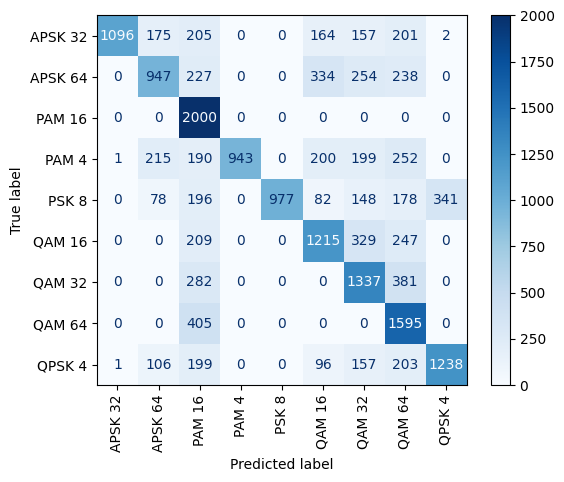

In [13]:

ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels_svm, xticks_rotation='vertical', cmap='Blues')
cls_rpt_svm = classification_report(test_labels, predicted_labels_svm)
print(cls_rpt_svm)


The SVM classifier yields and accuracy of 63%. This is not a bad accuracy, but it is not a good one either. We can try to improve this accuracy by using the optimum cumulants for the SVM classifier, a different kernel, or a different classifier altogether. We proceed to try the KNN classifier, see if it yields better results.

## KNN
We predict the labels of the testing dataset using the KNN classifier.

In [14]:
predicted_labels_knn = knn_classifier.predict(test_features.to_numpy())

Now, we view the classification report and the confusion matrix.

              precision    recall  f1-score   support

     APSK 32       0.98      0.56      0.72      2000
     APSK 64       0.89      0.46      0.61      2000
      PAM 16       0.60      1.00      0.75      2000
       PAM 4       1.00      0.49      0.66      2000
       PSK 8       1.00      0.48      0.65      2000
      QAM 16       0.51      0.61      0.55      2000
      QAM 32       0.53      0.67      0.59      2000
      QAM 64       0.45      0.86      0.59      2000
      QPSK 4       0.76      0.65      0.70      2000

    accuracy                           0.64     18000
   macro avg       0.74      0.64      0.65     18000
weighted avg       0.74      0.64      0.65     18000



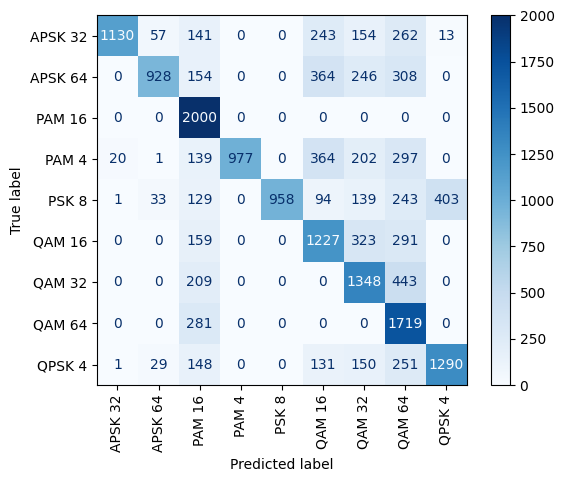

In [15]:
ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels_knn, xticks_rotation='vertical', cmap='Blues')
cls_rpt_knn = classification_report(test_labels, predicted_labels_knn)
print(cls_rpt_knn)

This is only one percent better than the SVM (64%). We try different values for K to see if we can improve the accuracy. We search for the best value of k arround the square root of the number of datapoints (45k).

In [16]:
k_start_idx =   int(int(np.sqrt(len(features))) -  0.5 * int(np.sqrt(len(features))))
k_end_idx =  int(int(np.sqrt(len(features))) +  0.5 * int(np.sqrt(len(features))))
k_values = np.arange(k_start_idx, k_end_idx, 2)

print(f"We start looping from {k_start_idx} to {k_end_idx}. Take the odd numbers only.")

# Create a list to store the accuracy values for each k value
accuracy_values = []

# Loop through the k values
for idx, k in enumerate(k_values):
    
        # Create a KNN classifier for each k value
        knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
        # Fit the classifier to the training data
        knn_classifier.fit(features.to_numpy(), np.ravel(labels.to_numpy()))
    
        # Predict the labels for the test features
        predicted_labels_knn = knn_classifier.predict(test_features.to_numpy())
    
        # Calculate the accuracy of the classifier
        accuracy = accuracy_score(test_labels, predicted_labels_knn)
    
        # Add the accuracy to the list along with its k value
        accuracy_values.append((k, accuracy))
        print(f"Trial {idx} out of {len(k_values)} |  K: {k} Accuracy: {accuracy}")


# Get the k value with the highest accuracy
# Use itemgetter to get the best k value
best_k = max(accuracy_values, key=itemgetter(1))[0]
best_accuracy = max(accuracy_values)[1]

# Print the best k value and its accuracy
print(f"The best k value is: {best_k} with an accuracy of: {best_accuracy*100:.2f}%")

We start looping from 106 to 318. Take the odd numbers only.
Trial 0 out of 106 |  K: 106 Accuracy: 0.6425
Trial 1 out of 106 |  K: 108 Accuracy: 0.6425
Trial 2 out of 106 |  K: 110 Accuracy: 0.6425555555555555
Trial 3 out of 106 |  K: 112 Accuracy: 0.6425555555555555
Trial 4 out of 106 |  K: 114 Accuracy: 0.6426111111111111
Trial 5 out of 106 |  K: 116 Accuracy: 0.6426111111111111
Trial 6 out of 106 |  K: 118 Accuracy: 0.6426111111111111
Trial 7 out of 106 |  K: 120 Accuracy: 0.6426111111111111
Trial 8 out of 106 |  K: 122 Accuracy: 0.6425555555555555
Trial 9 out of 106 |  K: 124 Accuracy: 0.6426111111111111
Trial 10 out of 106 |  K: 126 Accuracy: 0.6425555555555555
Trial 11 out of 106 |  K: 128 Accuracy: 0.6425555555555555
Trial 12 out of 106 |  K: 130 Accuracy: 0.6425555555555555
Trial 13 out of 106 |  K: 132 Accuracy: 0.6425555555555555
Trial 14 out of 106 |  K: 134 Accuracy: 0.6426111111111111
Trial 15 out of 106 |  K: 136 Accuracy: 0.6425555555555555
Trial 16 out of 106 |  K: 138

Now, visualize the results.

              precision    recall  f1-score   support

     APSK 32       0.98      0.56      0.72      2000
     APSK 64       0.88      0.46      0.61      2000
      PAM 16       0.60      1.00      0.75      2000
       PAM 4       1.00      0.49      0.66      2000
       PSK 8       1.00      0.48      0.65      2000
      QAM 16       0.51      0.61      0.56      2000
      QAM 32       0.53      0.68      0.59      2000
      QAM 64       0.45      0.86      0.59      2000
      QPSK 4       0.76      0.65      0.70      2000

    accuracy                           0.64     18000
   macro avg       0.74      0.64      0.65     18000
weighted avg       0.74      0.64      0.65     18000



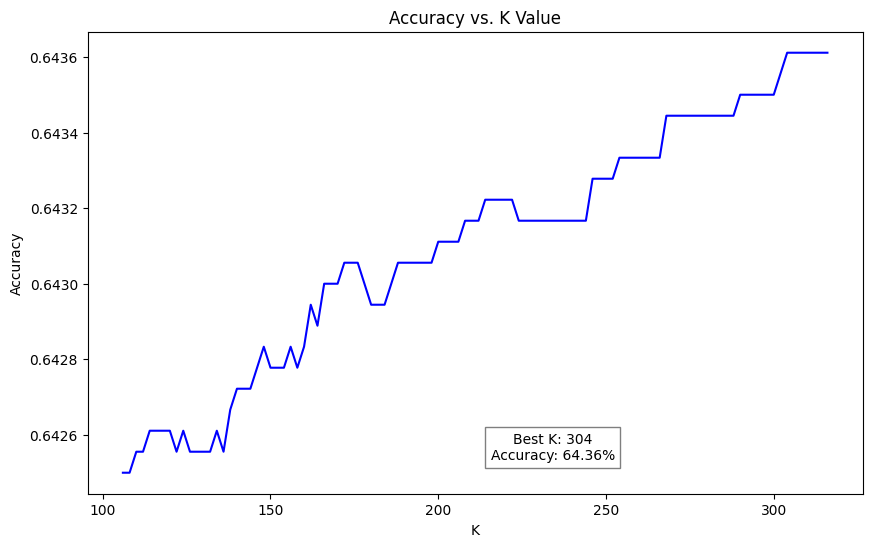

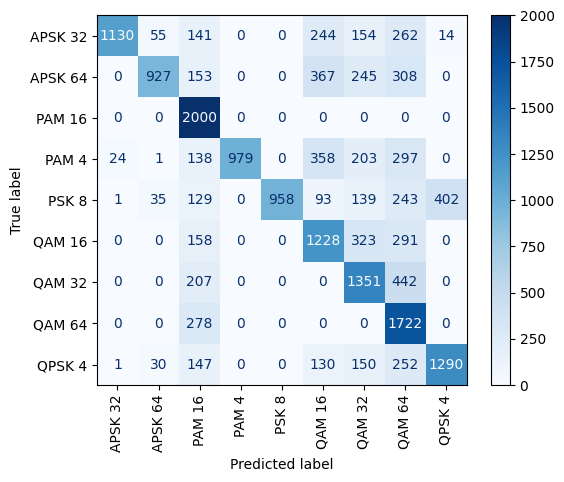

In [17]:
# Plot the accuracy values
plt.figure(figsize=(10, 6))
# Include only integers in the x axis ticks
#plt.xticks(np.arange(min(k_values), max(k_values)+1, 2.0))
plt.plot(k_values, [x[1] for x in accuracy_values], color='blue')
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

# Print in a box in the bottom right the best k value and its accuracy
plt.text(0.6, 0.1, f'Best K: {best_k}\nAccuracy: {best_accuracy*100:.2f}%', ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Create a KNN classifier with the best k value
knn_classifier_best = KNeighborsClassifier(n_neighbors=best_k)

# Fit the classifier to the training data
knn_classifier_best.fit(features.to_numpy(), np.ravel(labels.to_numpy()))

# Predict the labels for the test features
predicted_labels_knn_best = knn_classifier_best.predict(test_features.to_numpy())

# Classification report and confusion matrix
ConfusionMatrixDisplay.from_predictions(test_labels, predicted_labels_knn_best, xticks_rotation='vertical', cmap='Blues')

cls_rpt_knn_best = classification_report(test_labels, predicted_labels_knn_best)

print(cls_rpt_knn_best)


# Conclusion

We have used two algorithms to classify the modulation scheme of a given constellation. The first algorithm is the SVM classifier, and the second is the KNN classifier. We have used the first four cumulants as features. We have found that the SVM classifier yields an accuracy of 63%, and the KNN classifier yields an accuracy of 64%. We have tried different values for K in the KNN classifier, and we have found that the best value for K is 304. This value yields an accuracy of 64%. This is only 2% better than the SVM classifier. We can try to improve the accuracy by using the optimum cumulants for each classifier, a different kernel for the SVM, or by using a different classifier altogether.

Keep in mind that a trend in the values of k against the accuracy exists. The accuracy increases as the value of k increases. This is because the model is more robust to noise as the value of k increases. This is a good thing, but it comes at a cost. The cost is runtime for both finding k and for classification. The runtime of the KNN classifier increases as the value of k increases. This is because the model has to search for the k nearest neighbours for each datapoint in the testing dataset. This is a very expensive operation. We have to find a balance between accuracy and runtime. We have to find the value of k that yields the best accuracy with the least runtime. In our case, the best value of k is 304. 

Keep in mind that we cannot conclusively prove any results regarding which model is better, as the cumulants used are not the optimum cumulants for each classifier. We also still have another dataset that is larger in size that we haven't used for training. In our case, we can only say that the SVM classifier is slightly better than the KNN classifier becuase it is faster. An accuracy of 64% means that for each ten classifications the model makes, four of them will be incorrect. So an extra one percent in error wont make much difference as the best accuracy is very low. 